In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from local.torch_basics import *
from local.test import *
from local.basics import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
p = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
original_aud = AudioItem.create(files[0])

In [ ]:
a2s = AudioToSpec(n_fft = 1024, hop_length=256)

In [ ]:
original_spec = a2s(original_aud)

In [ ]:
type(original_spec[0])

torch.Tensor

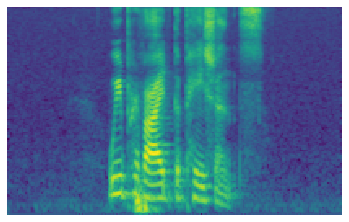

In [ ]:
original_spec.show()

In [ ]:
original_spec.n_fft

1024

# End-to-End Example

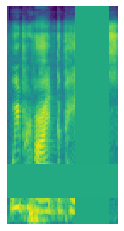

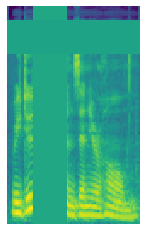

In [ ]:
items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(22050),]
augments = [AudioToSpec(n_fft=1048), MaskTime(), MaskFreq()]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

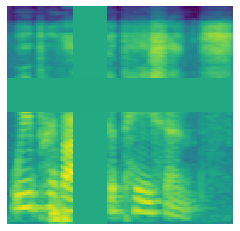

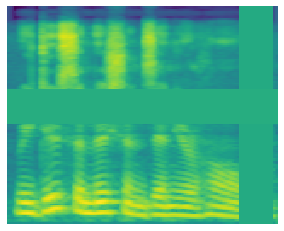

In [ ]:
items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = L(oa, RemoveSilence("trim"), Resample(22050), AudioToSpec(n_fft=2048, hop_length=256))
augments = L(MaskTime(), MaskFreq())
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

In [ ]:
# labeler = lambda x: str(x).split('/')[-1][:5]
# tfms = [[AudioItem.create, Resample(8000)], [labeler]]
# items = get_audio_files(p)

# tfds = TfmdDS(items, tfms)
# tfds.show(tfds[0])
# bs = 8
# tfdl = TfmdDL(tfds, bs=bs, after_item=[AudioToSpec(hop_length=256), CropTime(1000), MaskTime(), MaskFreq()])
# t = tfdl.one_batch()
# print(len(t[0]), "tensors with shapes", [ten.shape for ten in t[0]])
# print("labels", t[1])

## Datablock and Basic End to End Training

In [ ]:
def AudioBlock(cls=AudioItem): return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p)]

In [ ]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec()
crop_2000ms = CropTime(2000)
tfms = Pipeline([a2s, crop_2000ms], as_item=True)
dbunch_cropspec = auds.databunch(p, item_tfms=tfms, bs=64)

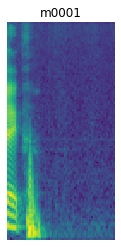

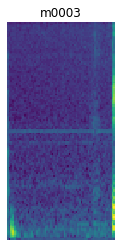

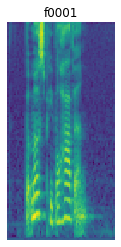

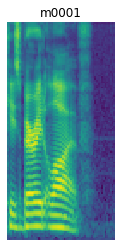

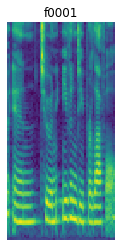

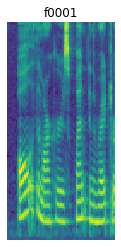

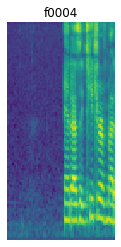

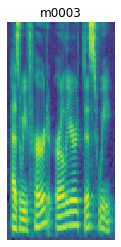

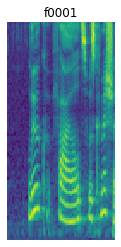

In [ ]:
dbunch_cropspec.show_batch(max_n=9)

In [ ]:
dbunch_cropspec.one_batch()[0].shape

torch.Size([64, 1, 128, 63])

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn):
    learn.model[0][0].in_channels=1
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch_cropspec, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
alter_learner(learn)

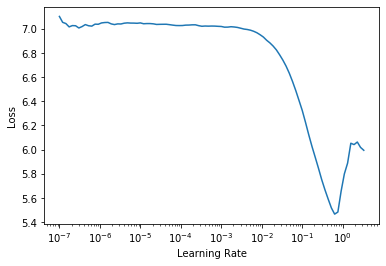

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,4.414924,2.224625,0.408854,00:06
1,2.098160,1.564576,0.494792,00:06
2,1.207936,0.792571,0.763021,00:06
3,0.779568,0.801433,0.739583,00:06
4,0.553784,0.759720,0.707031,00:06
5,0.431080,0.677614,0.769531,00:06
6,0.337672,0.291019,0.932292,00:06
7,0.287652,0.271402,0.936198,00:06
8,0.265727,0.248267,0.937500,00:06
9,0.248309,0.242732,0.955729,00:06


## Cropping signal instead of Spectrogram so that we can move on to GPU transforms

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
auds.datasource(p)[0]

((tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
           -6.1035e-05, -1.8311e-04]]),
  16000,
  PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')),
 tensor(3))

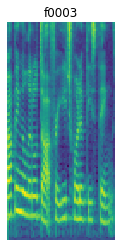

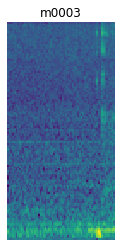

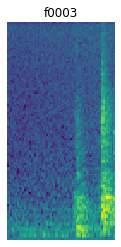

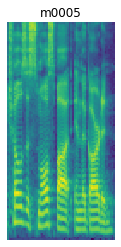

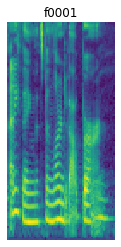

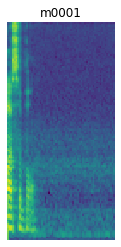

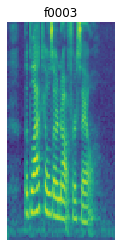

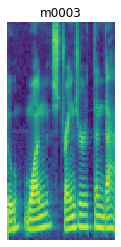

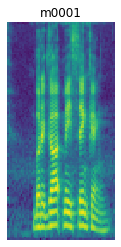

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)
ds_tfms = Pipeline([cropsig_2000ms, a2s], as_item=True)
dl_tfms = Pipeline([], as_item=True)
dbunch_cropsig = auds.databunch(p, item_tfms=ds_tfms, bs=64)
dbunch_cropsig.show_batch(max_n=9)

In [ ]:
dbunch_cropsig.one_batch()[0].shape

torch.Size([64, 1, 128, 63])

In [ ]:
learn = Learner(dbunch_cropsig,
                xresnet18(),  
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
alter_learner(learn)

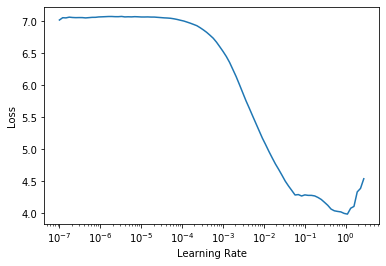

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-1)

epoch,train_loss,valid_loss,accuracy,time
0,3.424139,1.662483,0.410156,00:05
1,1.698475,2.482897,0.404948,00:05
2,1.058340,1.368424,0.519531,00:05
3,0.707638,0.797631,0.726562,00:05
4,0.491405,0.721889,0.756510,00:05
5,0.366936,0.473581,0.845052,00:05
6,0.274316,0.269948,0.917969,00:05
7,0.210735,0.184938,0.944010,00:05
8,0.181348,0.184647,0.951823,00:05
9,0.155457,0.149824,0.971354,00:05


In [ ]:
learn.unfreeze()

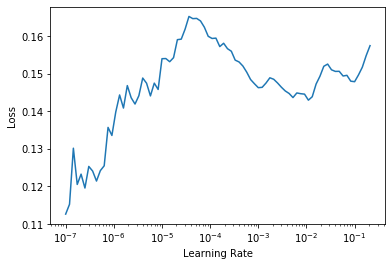

In [ ]:
learn.lr_find()

## Non GPU Transform for Speed Baseline

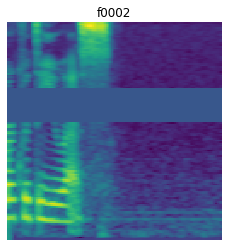

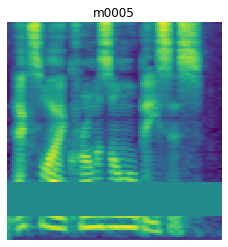

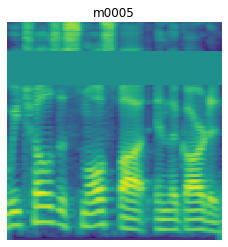

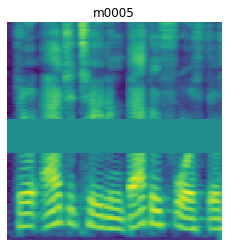

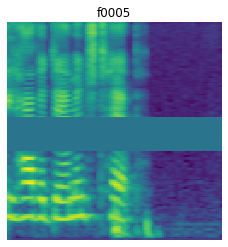

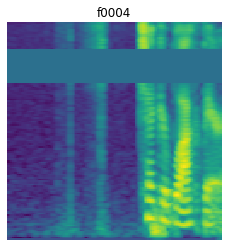

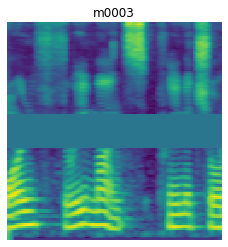

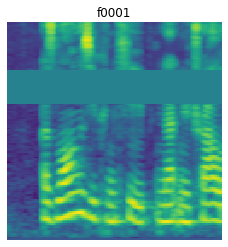

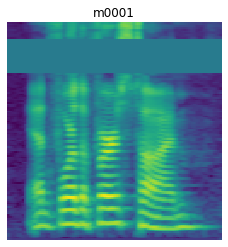

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)
a2s_baseline = AudioToSpec(n_fft=2048, hop_length=256, n_mels=128)
ds_tfms = Pipeline([cropsig_2000ms, a2s_baseline, MaskFreq()], as_item=True)
dbunch_cropsig = auds.databunch(p, item_tfms=ds_tfms, bs=64)
dbunch_cropsig.show_batch(max_n=9)

In [ ]:
dbunch_cropsig.one_batch()[0].shape

torch.Size([64, 1, 128, 126])

In [ ]:
learn = Learner(dbunch_cropsig,
                xresnet18(),  
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
alter_learner(learn)

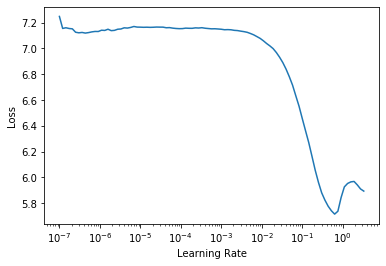

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-1)

epoch,train_loss,valid_loss,accuracy,time
0,3.652295,1.870576,0.376302,00:08
1,1.985800,1.958696,0.326823,00:08
2,1.331710,1.613323,0.463542,00:08
3,0.894089,2.228370,0.363281,00:08
4,0.639595,1.019268,0.643229,00:08
5,0.465826,0.746748,0.705729,00:08
6,0.345194,0.307814,0.904948,00:08
7,0.271817,0.207761,0.962240,00:08
8,0.225982,0.178370,0.972656,00:08
9,0.204515,0.178388,0.959635,00:08


## Attempted GPU Transform

In [ ]:
def MaskFreqBatch(num_masks=1, size=20, start=None, val=None, **kwargs):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape[-3:]
        for _ in range(num_masks):
            #print("Mask Val", mask_val)
            #Currently not worrying about getting the channel mean from batchwise implementation
            mask = torch.ones(size, x, device=device).unsqueeze(0).unsqueeze(0) #* mask_val    
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[...,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)

In [ ]:
def SGRollBatch(max_shift_pct=0.5, direction=0, **kwargs):
    '''Shifts spectrogram along x-axis wrapping around to other side'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        nonlocal direction
        direction = random.choice([-1, 1]) if direction == 0 else direction
        sg = spectro.clone()
        c, height, width = sg.shape[-3:]
        roll_by = int(width*random.random()*max_shift_pct*direction)
        sg = sg.roll(roll_by, dims=-1)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

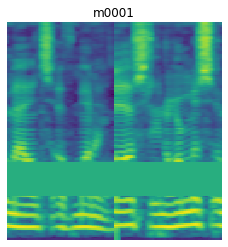

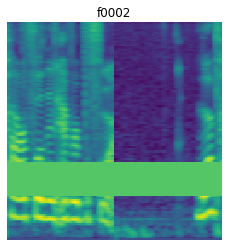

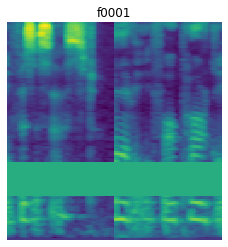

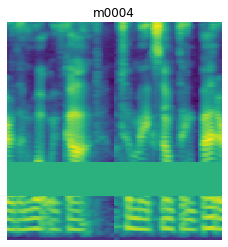

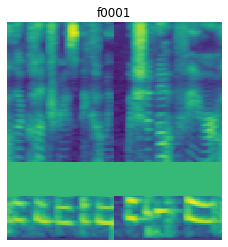

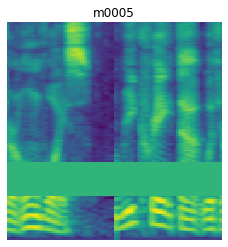

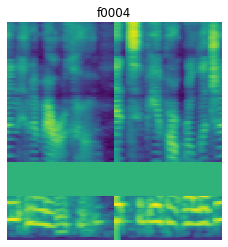

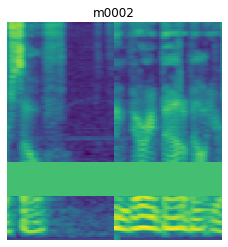

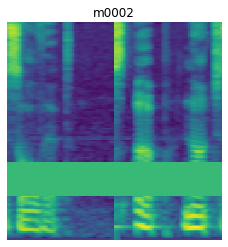

In [ ]:
ds_tfms = Pipeline([cropsig_2000ms, a2s_baseline], as_item=True)
dl_tfms = Pipeline([Cuda(), MaskFreqBatch(), SGRollBatch()], as_item=True)
dbunch = auds.databunch(p, item_tfms=ds_tfms, batch_tfms=dl_tfms, bs=64)
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 126])

In [ ]:
learn = Learner(dbunch,
                xresnet18(),  
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
alter_learner(learn)

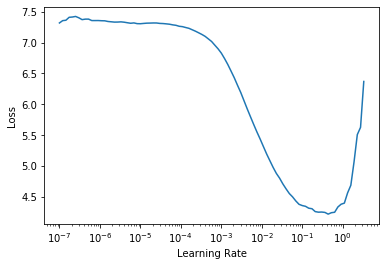

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.698359,2.348536,0.433594,00:08
1,0.952088,4.605072,0.403646,00:07
2,0.693933,4.436698,0.389323,00:07
3,0.472264,2.459136,0.511719,00:07
4,0.297620,1.183429,0.716146,00:07
5,0.238046,1.062236,0.734375,00:07
6,0.158020,0.352445,0.891927,00:07
7,0.099811,0.135392,0.958333,00:07
8,0.076432,0.082720,0.972656,00:07
9,0.058143,0.078757,0.971354,00:07


## 2nd Attempt with correct mean channel values

In [ ]:
def MaskFreqBatchValue(num_masks=1, size=20, start=None, val=None, **kwargs):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None,None]
        mask_val = channel_mean if val is None else val
        b, c, y, x = sg.shape
        for _ in range(num_masks):
            ones_mask = torch.ones(size=(1, c, size, x), device=device)
            mask = ones_mask * mask_val
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,:,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
(torch.ones(size=(64,1,20,128)) * 12).shape

torch.Size([64, 1, 20, 128])

In [ ]:
ds_tfms = Pipeline([cropsig_2000ms, a2s_baseline], as_item=True)
dl_tfms = Pipeline([Cuda(), MaskFreqBatchValue()], as_item=True)
dbunch = auds.databunch(p, item_tfms=ds_tfms, batch_tfms=dl_tfms, bs=64)
dbunch.show_batch(max_n=9)

TypeError: super(type, obj): obj must be an instance or subtype of type

## 3rd Attempt with correct random placement of mask

In [ ]:
def MaskFreqBatchPlace(num_masks=1, size=20, start=None, val=None, **kwargs):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None,None]
        mask_val = channel_mean if val is None else val
        b, c, y, x = sg.shape
        for _ in range(num_masks):
            ones_mask = torch.ones(size=(1, c, size, x), device=device)
            mask = ones_mask * mask_val
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            start_test = np.arange(0,,1)
            #print("Index: shape", start_test.shape)
            sg[:,:,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

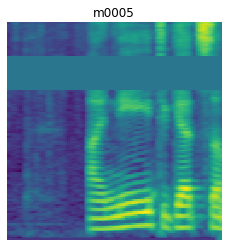

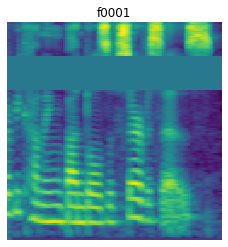

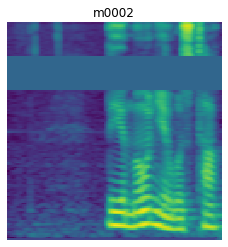

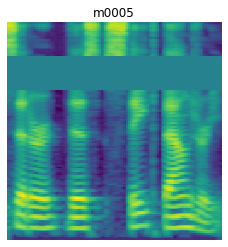

In [ ]:
ds_tfms = Pipeline([cropsig_2000ms, a2s_baseline], as_item=True)
dl_tfms = Pipeline([Cuda(), MaskFreqBatchPlace()], as_item=True)
dbunch = auds.databunch(p, item_tfms=ds_tfms, batch_tfms=dl_tfms, bs=4)
dbunch.show_batch(max_n=9)

In [ ]:
(torch.ones(size=(64,1,20,128)) * 12).shape

torch.Size([64, 1, 20, 128])

In [ ]:
fake_batch = torch.stack([CropTime(2000)(a2s(AudioItem.create(files[i]))) for i in range(64)])

In [ ]:
fake_batch.shape

torch.Size([64, 1, 128, 63])

In [ ]:
index = np.array([2,4,6,8], dtype=np.intp)

In [ ]:
index + 20

array([22, 24, 26, 28])

In [ ]:
fake_batch[:,:,index:index+20,:]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
fake_batch[:,:,torch.arange(0, 7).long(),:].shape

torch.Size([64, 1, 7, 63])